In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
metadata = pd.read_csv("../HAM10000_metadata.csv")
metadata.describe(include="all")

lesion_id      image_id     dx dx_type          age    sex  \
count         10015         10015  10015   10015  9958.000000  10015   
unique         7470         10015      7       4          NaN      3   
top     HAM_0000835  ISIC_0028505     nv   histo          NaN   male   
freq              6             1   6705    5340          NaN   5406   
mean            NaN           NaN    NaN     NaN    51.863828    NaN   
std             NaN           NaN    NaN     NaN    16.968614    NaN   
min             NaN           NaN    NaN     NaN     0.000000    NaN   
25%             NaN           NaN    NaN     NaN    40.000000    NaN   
50%             NaN           NaN    NaN     NaN    50.000000    NaN   
75%             NaN           NaN    NaN     NaN    65.000000    NaN   
max             NaN           NaN    NaN     NaN    85.000000    NaN   

       localization  
count         10015  
unique           15  
top            back  
freq           2192  
mean            NaN  
std             NaN  
min             NaN  
25%             NaN  
50%             NaN  
75%             NaN  
max             NaN

In [7]:
print(metadata.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [8]:
labels = list(metadata.dx.unique())
print(labels)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


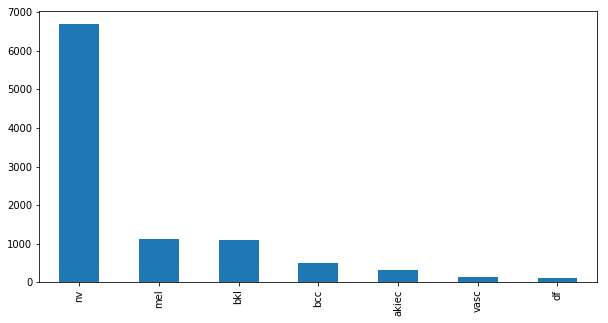

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
counts = metadata["dx"].value_counts()
print(counts)
counts.plot(kind='bar', ax=ax1)
#metadata["dx"].hist()

In [10]:
# parse out all classes to individual dataframes
nv = metadata[metadata["dx"] == "nv"]
mel = metadata[metadata["dx"] == "mel"]
bkl = metadata[metadata["dx"] == "bkl"]
bcc = metadata[metadata["dx"] == "bcc"]
akiec = metadata[metadata["dx"] == "akiec"]
vasc = metadata[metadata["dx"] == "vasc"]
df = metadata[metadata["dx"] == "df"]
# list out
classes = [nv, mel, bkl, bcc, akiec, vasc, df]

In [13]:
# preprocess accordingly
def preprocess(_image):
    #_image = cv2.cvtColor(_image, cv2.COLOR_BGR2RGB)
    
    _image = cv2.equalizeHist(_image) 
    #_image = cv2.GaussianBlur(_image, (3,3), 1)
    #_image = cv2.cvtColor(_image, cv2.COLOR_RGB2HSV)
    #H,S,V = cv2.split(_image)
    #_V = cv2.equalizeHist(V) 
    #_image = cv2.merge([H, S, _V])
    #_image = cv2.cvtColor(_image, cv2.COLOR_HSV2RGB)
    
    return _image

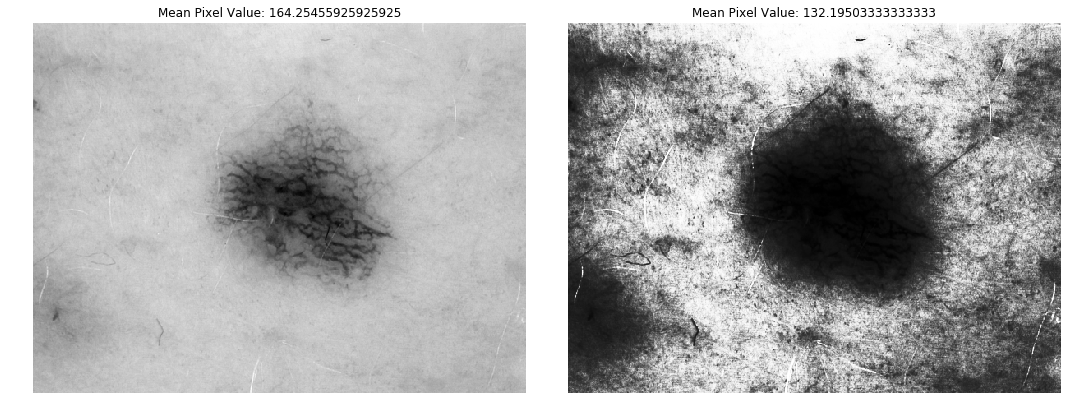

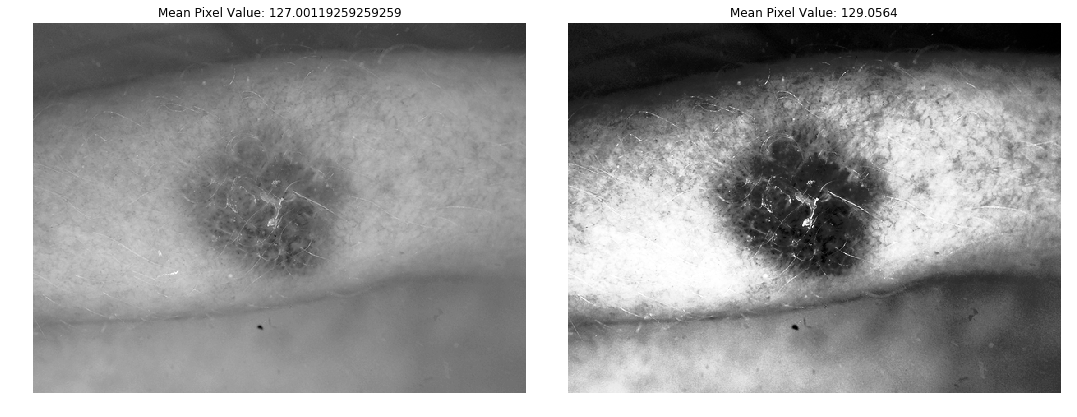

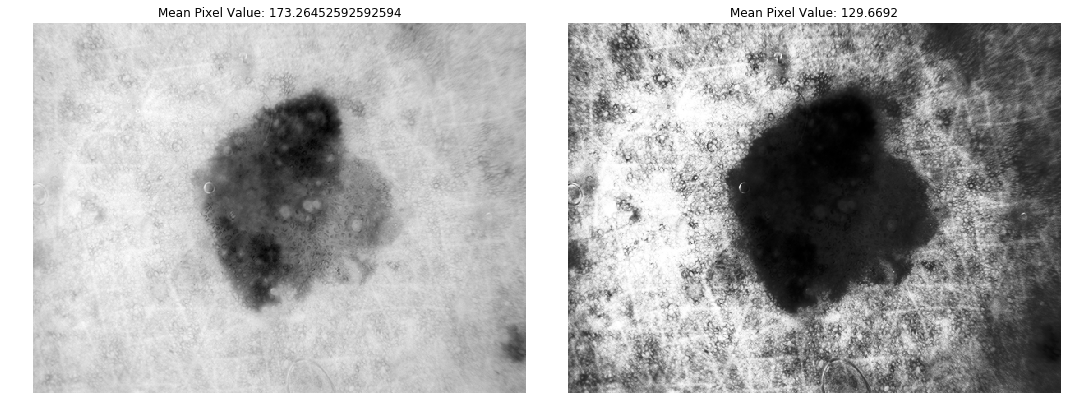

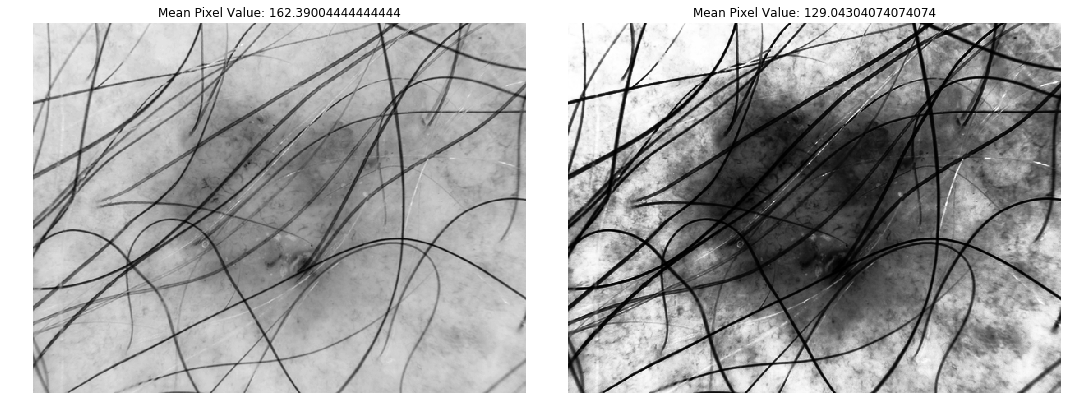

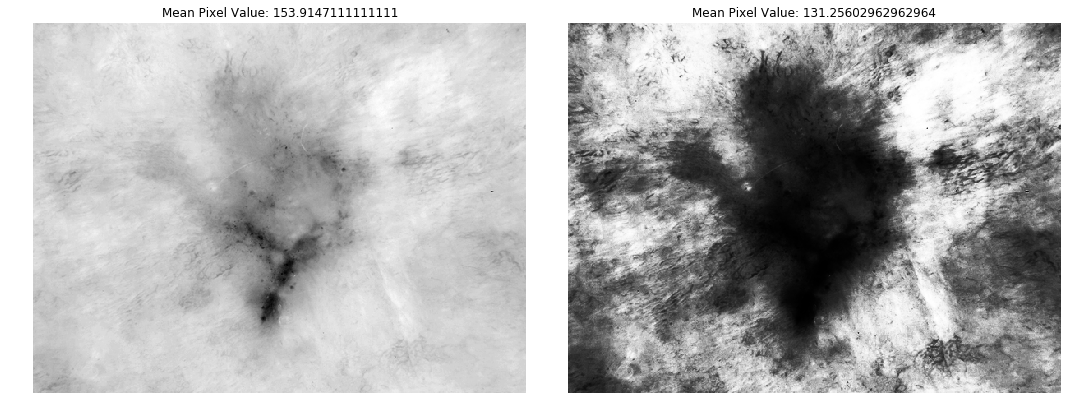

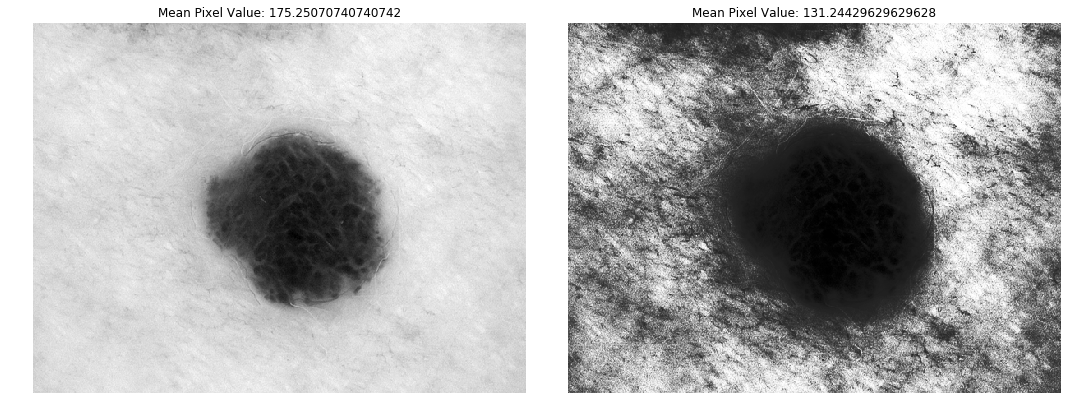

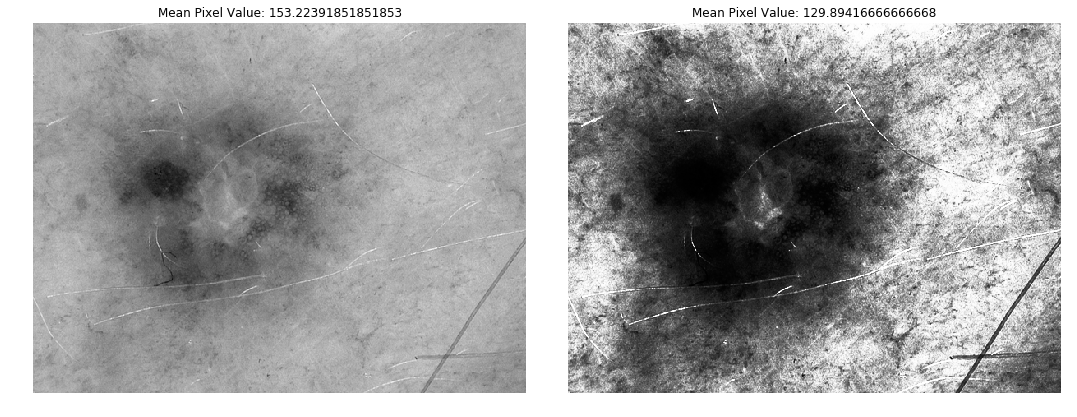

In [14]:
# apply preprocesing and display both side by side for each class
num_images = 2
for _class in classes:
    # plotting
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 15), squeeze=False)
    fig.tight_layout()
    row = _class.sample(n=1)
    _id = row["image_id"].to_string(index=False).strip()
    image = cv2.imread("../ham10000/{}.jpg".format(_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_preprocessed = preprocess(image)
    for l in range(1):
        for m, img in enumerate([image, image_preprocessed]):
            axes[l][m].imshow(img, cmap="gray")
            axes[l][m].axis("off")
            axes[l][m].set_title("Mean Pixel Value: {}".format(np.mean(img)))

## Feature Extraction and CNN Setup

In [17]:
import h5py

class HDF5IO:

    def __init__(self, dims, outputPath, dataKey="images", bufSize=1000):
        if os.path.exists(outputPath):
            raise ValueError(
                "The path already exists and cannot be overwritten", 
                outputPath
            )
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(
            dataKey,
            dims,
            dtype="float"
        )
        self.labels = self.db.create_dataset(
            "labels",
            (dims[0],),
            dtype="int"
        )
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0
        
    def add(self, rows, labels):
        """
        Adds the rows and labels to the buffer
        :param rows:
        :param labels:
        :return:
        """
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)
        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()
    
    def flush(self):
        """
        Write the buffers to disk then reset the buffer
        :return:
        """
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def store_class_labels(self, classLabels):
        """
        create a dataset to store the actual class label names,
        then store the class labels
        :return:
        """
        dt = h5py.special_dtype(vlen=str)
        labelSet = self.db.create_dataset(
            "label_names",
            (len(classLabels), ), 
            dtype=dt
        )
        labelSet[:] = classLabels

    def close(self):
        """
        Closes the dataset
        :return:
        """
        if len(self.buffer["data"]) > 0:
            self.flush()
        # close the dataset
        self.db.close()